<a href="https://colab.research.google.com/github/darshtripathi10/EY_CASESTUDY_ANALYSIS/blob/main/EY_FOOD_CASESTUDY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Upload the following files: 
- food_delivery_data.csv 
- food_delivery_data_with_demographics.csv 
- food_delivery_data_with_food_type.csv


Saving food_delivery_data_with_demographics.csv to food_delivery_data_with_demographics (2).csv
Saving food_delivery_data.csv to food_delivery_data (2).csv
Saving food_delivery_data_with_food_type.csv to food_delivery_data_with_food_type (2).csv


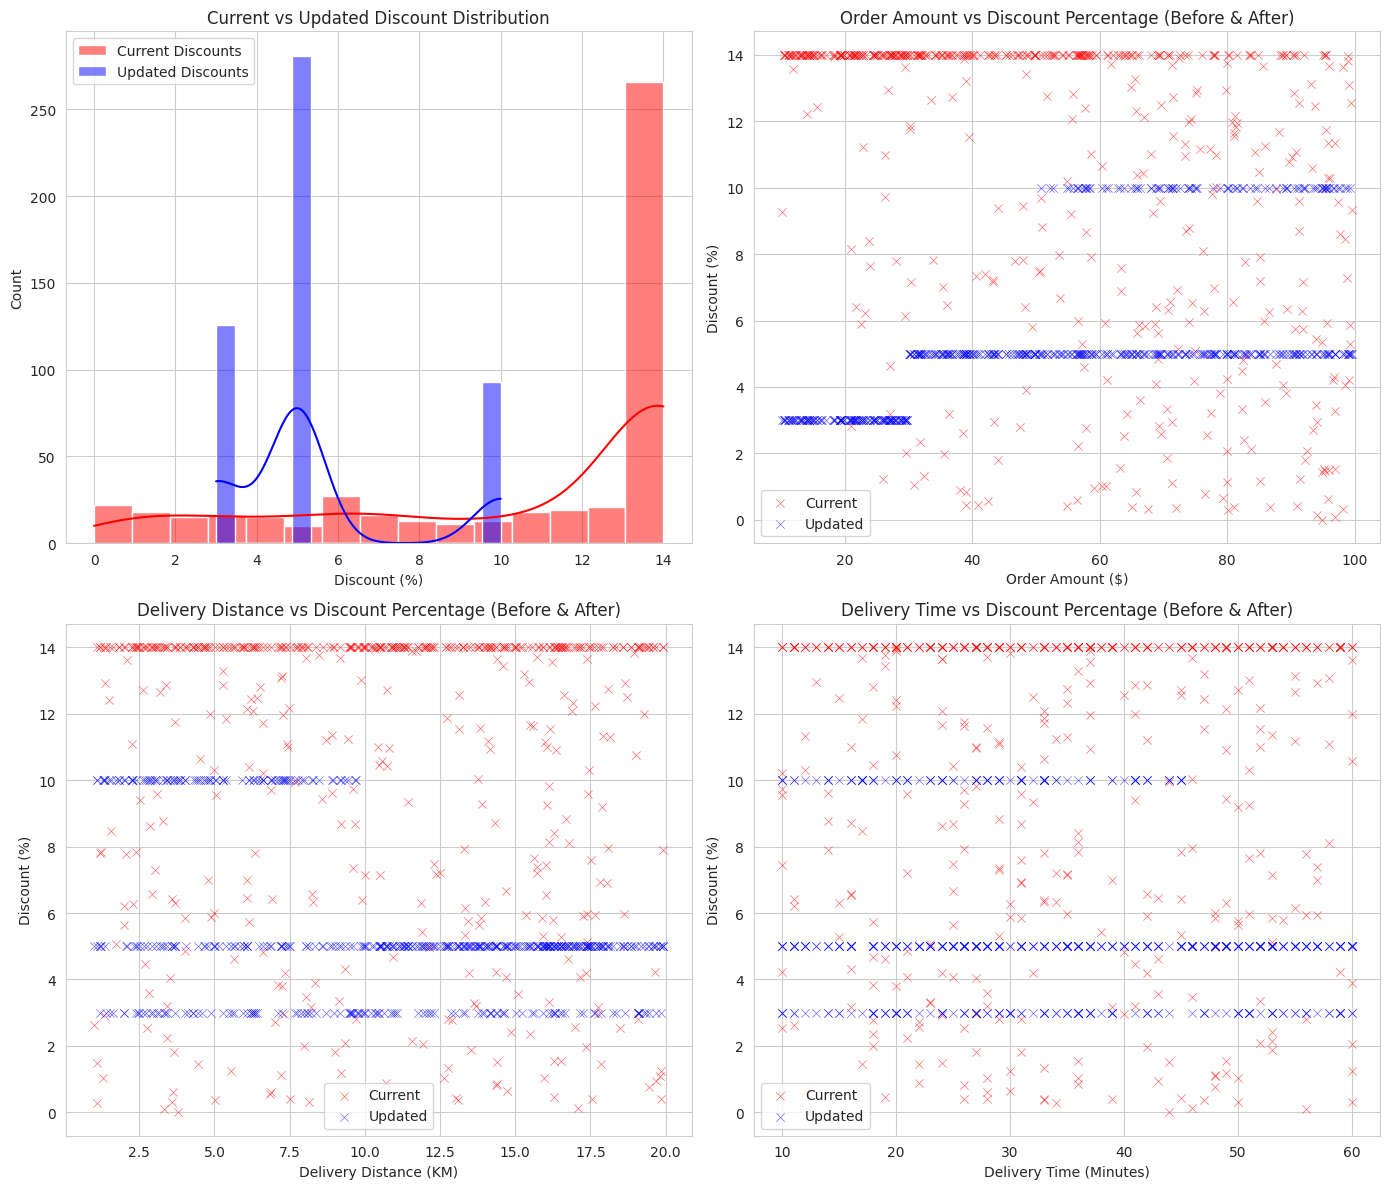

Revenue After Current Discounts: $24,630.65
Revenue After Updated Discounts: $25,566.93
Total Discount Reduction: $936.28


In [3]:
# Step 1: Install Required Libraries (if not installed)
!pip install pandas matplotlib seaborn --quiet

#  Step 2: Import Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

#  Step 3: Upload CSV Files
print("📂 Upload the following files: \n- food_delivery_data.csv \n- food_delivery_data_with_demographics.csv \n- food_delivery_data_with_food_type.csv")
uploaded = files.upload()

#  Step 4: Load the Datasets
df_orders = pd.read_csv("food_delivery_data.csv")
df_demographics = pd.read_csv("food_delivery_data_with_demographics.csv")
df_food = pd.read_csv("food_delivery_data_with_food_type.csv")

#  Step 5: Merge All Datasets
df = df_orders.merge(df_demographics, on=["OrderID", "CustomerID", "OrderDate"], how="left")
df = df.merge(df_food, on=["OrderID", "CustomerID", "OrderDate"], how="left")

#  Step 6: Data Cleaning
df["OrderAmount"] = df["OrderAmount"].replace("[$,]", "", regex=True).astype(float)

# Convert DiscountApplied to percentage
df["DiscountPercentage"] = (df["DiscountApplied"] / df["OrderAmount"]) * 100

# Ensure discount percentage is within 0-14%
df["DiscountPercentage"] = df["DiscountPercentage"].clip(0, 14)

#  Step 7: Define the Final Discount Strategy Function
def final_discount_strategy(order_amount, delivery_distance, delivery_time, gender, food_type, referral_status):
    # Base Discount (3-5-10% Model)
    if order_amount < 30:
        base_discount = 3  # 3%
    elif 30 <= order_amount < 50:
        base_discount = 5  # 5%
    else:
        base_discount = 10  # 10%

    # Distance-Based Cap: If distance > 10KM, max discount is 5%
    if delivery_distance > 10:
        base_discount = min(base_discount, 5)

    # Ensure all high-value orders ($60+) get at least a 5% discount
    if order_amount > 60:
        base_discount = max(base_discount, 5)

    # Gender-Based Discounts
    if gender == "Female":
        base_discount += 2  # Extra 2% for women
    elif gender == "Other":
        base_discount += 3  # Extra 3% for inclusivity

    # Food Type-Based Discounts
    if food_type in ["Salad", "Vegan", "Gluten-Free"]:
        base_discount += 2  # Healthy food discount
    elif food_type == "Dessert":
        base_discount += 1  # Dessert discount

    # Referral-Based Discounts
    if referral_status == "New":
        base_discount += 3  # New customer referral
    elif referral_status == "Existing":
        base_discount += 2  # Referring customer gets 2%

    # Delivery Time-Based Cap: If delivery time > 45 min, max discount is 5%
    if delivery_time > 45:
        base_discount = min(base_discount, 5)

    # Cap final discount at 14% to avoid excessive discounts
    return min(base_discount, 14)

#  Step 8: Apply the Final Discount Strategy to the Dataset
df["UpdatedDiscountPercentage"] = df.apply(
    lambda row: final_discount_strategy(
        row["OrderAmount"], row["DeliveryDistanceKM"], row["DeliveryTimeMin"],
        row["Gender"], row["FoodType"], row["ReferralStatus"] if "ReferralStatus" in row else None
    ), axis=1
)

#  Step 9: Generate Comparison Visualizations
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Discount Distribution (Current vs Updated)
sns.histplot(df["DiscountPercentage"], bins=15, kde=True, ax=axes[0, 0], color="red", label="Current Discounts")
sns.histplot(df["UpdatedDiscountPercentage"], bins=15, kde=True, ax=axes[0, 0], color="blue", label="Updated Discounts")
axes[0, 0].set_title("Current vs Updated Discount Distribution")
axes[0, 0].set_xlabel("Discount (%)")
axes[0, 0].legend()

# Order Amount vs Discount Percentage
sns.scatterplot(data=df, x="OrderAmount", y="DiscountPercentage", alpha=0.6, ax=axes[0, 1], color="red", marker='x', label="Current")
sns.scatterplot(data=df, x="OrderAmount", y="UpdatedDiscountPercentage", alpha=0.6, ax=axes[0, 1], color="blue", marker='x', label="Updated")
axes[0, 1].set_title("Order Amount vs Discount Percentage (Before & After)")
axes[0, 1].set_xlabel("Order Amount ($)")
axes[0, 1].set_ylabel("Discount (%)")
axes[0, 1].legend()

# Delivery Distance vs Discount Percentage
sns.scatterplot(data=df, x="DeliveryDistanceKM", y="DiscountPercentage", alpha=0.6, ax=axes[1, 0], color="red", marker='x', label="Current")
sns.scatterplot(data=df, x="DeliveryDistanceKM", y="UpdatedDiscountPercentage", alpha=0.6, ax=axes[1, 0], color="blue", marker='x', label="Updated")
axes[1, 0].set_title("Delivery Distance vs Discount Percentage (Before & After)")
axes[1, 0].set_xlabel("Delivery Distance (KM)")
axes[1, 0].set_ylabel("Discount (%)")
axes[1, 0].legend()

# Delivery Time vs Discount Percentage
sns.scatterplot(data=df, x="DeliveryTimeMin", y="DiscountPercentage", alpha=0.6, ax=axes[1, 1], color="red", marker='x', label="Current")
sns.scatterplot(data=df, x="DeliveryTimeMin", y="UpdatedDiscountPercentage", alpha=0.6, ax=axes[1, 1], color="blue", marker='x', label="Updated")
axes[1, 1].set_title("Delivery Time vs Discount Percentage (Before & After)")
axes[1, 1].set_xlabel("Delivery Time (Minutes)")
axes[1, 1].set_ylabel("Discount (%)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Step 10: Financial Impact Analysis
df["CurrentDiscountAmount"] = (df["DiscountPercentage"] / 100) * df["OrderAmount"]
df["UpdatedDiscountAmount"] = (df["UpdatedDiscountPercentage"] / 100) * df["OrderAmount"]

# Compute total revenue before and after discounting
total_revenue = df["OrderAmount"].sum()
revenue_after_current_discounts = total_revenue - df["CurrentDiscountAmount"].sum()
revenue_after_updated_discounts = total_revenue - df["UpdatedDiscountAmount"].sum()

# Display financial impact
print(f"Revenue After Current Discounts: ${revenue_after_current_discounts:,.2f}")
print(f"Revenue After Updated Discounts: ${revenue_after_updated_discounts:,.2f}")
print(f"Total Discount Reduction: ${df['CurrentDiscountAmount'].sum() - df['UpdatedDiscountAmount'].sum():,.2f}")
